# Transformer core concepts

The outline of this notebook follow closely the blog post _TRANSFORMERS FROM SCRATCH_ by [Peter Boem](https://peterbloem.nl/blog/transformers) with some modifications.


## Refresher: Matrix multiplication

Before we continue, however, it is a good idea to take a little refresher on _matrix multiplication_. Let's take matrices $M$ and $N$ as an example. $M$ has 2 rows ($i$) and 4 columns ($j$), while $N$ has 4 rows and 2 columns. 

To multiply these matrices, we start by taking the dot product ($\times$) of the first row of $M$ with the first column of $N$. To do this, we multiply the first element in the first row of $M$ with the first element in the first column of $N$, then add the result to the product of the second element in the first row of $M$ and the second element in the first column of $N$, and so on for all four elements in the row and column.

We repeat this process for all rows in $M$ and all columns in $N$, and write the results into a new matrix that has the same number of rows as $M$ and the same number of columns as $N$. In this example, the resulting matrix would have 2 rows and 2 columns.

The above process is depicted below.

![image](../../diagrams/matrix-multiplication.png)


## Embedding vectors

The intuition behind embedding tokens to a vector is to represent each word or subword in a text as a numerical vector that captures its meaning and relationship to other words in the text. This is the basic idea behind word embeddings and subword embeddings, which are widely used in natural language processing (NLP) tasks.

The key intuition behind embeddings is that words or subwords that have similar meanings or are used in similar contexts should be represented by similar or nearby embedding vectors in the high-dimensional space. This allows the embedding vectors to capture semantic and syntactic relationships between words, such as synonyms, antonyms, and analogies. For example, the embedding vectors for "dog" and "cat" might be closer together than the embedding vectors for "dog" and "car", reflecting their semantic similarity.


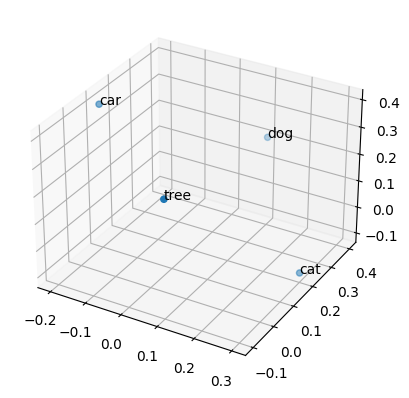

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define some example vocabulary and corresponding embedding vectors
vocab = ["cat", "dog", "car", "tree"]
embeddings = np.array([
    [0.3, 0.2, -0.1],
    [0.1, 0.4, 0.2],
    [-0.2, 0.1, 0.4],
    [0.1, -0.1, 0.3]
])

# Define a function to plot the embeddings in 3D space
def plot_embeddings_3d(vocab, embeddings):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embeddings[:,0], embeddings[:,1], embeddings[:,2])
    for i, word in enumerate(vocab):
        ax.text(embeddings[i,0], embeddings[i,1], embeddings[i,2], word)
    plt.show()

# Visualize the embeddings in 3D space
plot_embeddings_3d(vocab, embeddings)

Embeddings can be learned from scratch on a specific task or dataset, or they can be pre-trained on large amounts of unlabeled data and then fine-tuned on smaller labeled datasets for specific tasks. Pre-trained embeddings, such as those used in BERT, have been shown to be highly effective for a wide range of NLP tasks and are widely used in the field. What is most important is that with embeddings text can be given to neural network in numerical format.

### Positional encoding

The intuition behind positional encoding is to inject some notion of word order or position into the embedding vectors, which is necessary for sequence-to-sequence models like transformers that process variable-length input sequences.

In natural language processing (NLP), word order is critical to understanding the meaning of a sentence or paragraph. However, traditional word embeddings like word2vec or GloVe do not capture any information about word order or position in the input sequence. This means that a traditional embedding alone would not be sufficient for a model like a transformer to fully understand a given text.

Positional encoding addresses this limitation by adding an additional vector to the word embeddings that encodes the position of each word in the sequence. This vector is added to the input embeddings before they are passed through the transformer layers, allowing the model to better understand the relationships between words based on their position in the sequence.

The formula for computing the positional encoding vector for a word at a given position $\text{pos}$ and dimension $i$ is:

$$\begin{aligned}
PE_{pos,2i} & = \text{sin} \left( \frac{pos}{10000^{2i/d_{embed}}} \right)\text{,  if }i\text{ is even} \\
PE_{pos,2i+11} & = \text{cos} \left( \frac{pos}{10000^{2i/d_{embed}}} \right)\text{,  if }i\text{ is odd} \\
\end{aligned}$$

Here, $\text{pos}$ is the position of the word in the sequence, $i$ is the dimension of the positional encoding vector, and $d_{embed}$ is the dimension of the input embeddings. The value 10000 is a hyperparameter that determines the scale of the sine and cosine functions. 

Let's use an example. Let's assume that the word ``hello`` maps to an embedding vector ``[0.1, 0.2]``. Below is in an illustration how applying positional encoding to the vector in different changes the original embedding values. In other words, the the sentence we're using is

        ["hello", "hello", "hello", "hello"]

or

        [[0.1, 0.2], [0.1, 0.2], [0.1, 0.2], [0.1, 0.2]]

Let's see how the vectors change when the position of the token changes.

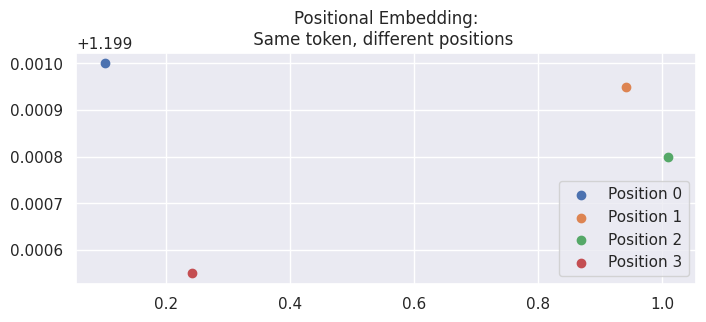

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

def positional_encoding(pos, embedding_dim):
    pe = np.zeros((embedding_dim,))
    for i in range(0, embedding_dim, 2):
        pe[i] = np.sin(pos / (10000 ** (i / embedding_dim)))
        pe[i + 1] = np.cos(pos / (10000 ** ((i + 1) / embedding_dim)))
    return pe

embedding = [0.1, 0.2]
embeddings = np.array([embedding, embedding, embedding, embedding])

pos_encodings = np.zeros((len(embeddings), len(embedding)))
for pos in range(len(embeddings)):
    pos_encodings[pos] = positional_encoding(pos, len(embedding))

pos_embed = embeddings + pos_encodings

fig, ax = plt.subplots(figsize=(8, 3))
for i in range(len(embeddings)):
    ax.scatter(pos_embed[i, 0], pos_embed[i, 1], label=f"Position {i}")
ax.set_title("Positional Embedding:\n Same token, different positions  ")
ax.legend()
plt.show()


## Self-attention


### General intuition

The attention mechanism is like a teacher who helps you focus on what's important in a classroom. In the same way, the attention mechanism helps the transformer focus on which parts of the input it should be paying attention to, when processing information.

The attention mechanism in transformers allows the model to weigh the importance of different parts of the input, giving more emphasis to the parts that are more relevant to the output.

This is done by computing **attention scores** between each pair of input elements (e.g. words in a sentence) and then using these scores to compute a **weighted sum of the input elements**. The attention **scores are computed using a learned function (_neural network_)** that takes as input both the current input element and a "query" vector that represents the current state of the model.

The resulting **weighted sum is then used as input** to the next layer of the transformer.

### Basic self-attention

We’ll start by implementing this basic self-attention operation in Pytorch. The first thing we should do is work out how to express the self attention in matrix multiplications. 

There are no parameters in basic self-attention (yet). What the basic self-attention actually does is entirely determined by whatever mechanism creates the input sequence. Upstream mechanisms, like an embedding layer, drive the self-attention by learning representations with particular dot products (although we’ll add a few parameters later).

Self attention sees its input as a set, not a sequence. If we permute the input sequence, the output sequence will be exactly the same, except permuted also (i.e. self-attention is permutation equivariant). We will mitigate this somewhat when we build the full transformer, but the self-attention by itself actually ignores the sequential nature of the input.

For an input sequence $x$, basic self-attention for each token $x_i$ can be defined as

$$\begin{aligned}
w'_i & = x_i^Tx_i \\
w_i & = \text{softmax}(w'_i) \\
y_i & =  w_ix_i \\
\end{aligned}$$
where $w'_i$ are the raw weights, $w_i$ the scaled weights and $y_i$ the output of the self-attention mechanism. 
> __From this definition it is explicit, that the self-attention is calculated for each input token separately, i.e. the context of the whole sequence is not used.__

Using the above definitions, the illustrated process of perorming basic self-attention on an input is depicted below. First the raw weights $w'_i$ are calculated:

![image](../../diagrams/basic-self-attention-raw-weight.png)

Next, the raw weights are scaled:

![image](../../diagrams/basic-self-attention-weight.png)

Lastly, the input is weighted, producing the self-attention output:

![image](../../diagrams/basic-self-attention-output.png)

Let's define a function to demonstrate basic self-attention. The `apply_self_attention` function generates random sequences of embeddings, computes raw and scaled weights for each token in the sequence using the self-attention mechanism, and applies the attention to the embeddings to obtain an attention-weighted output.

Additionally, we are using the `visualize_self_attention` function from the `visualize.py` in the current workshop notebook folder. 

In [1]:
import torch
import torch.nn.functional as F
from visualize import visualize_self_attention


def apply_self_attention(
    sequences, tokens_in_sequence, embedding_vector_dims, visualize=True
):
    """
    Apply self-attention mechanism to a random sequence of embeddings.
    """
    x = torch.rand(sequences, tokens_in_sequence, embedding_vector_dims)
    print({"x.shape": x.shape})

    raw_weights = torch.bmm(x, x.transpose(1, 2))
    print({"raw_weights.shape": raw_weights.shape})

    weights = F.softmax(raw_weights, dim=2)
    print({"weights.shape": weights.shape})

    y = torch.bmm(weights, x)
    print({"y.shape": y.shape})

    if visualize:
        visualize_self_attention(x, raw_weights, weights, y)


Let's then try to visualize what the attention does. Let's begin by looking at a single token sequence. The legend for notation is the following:
 - $S_0$ is the first sequence of tokens in the input batch
 - $T$ are the token-wise embedding vectors in an input sequence

{'x.shape': torch.Size([1, 1, 4])}
{'raw_weights.shape': torch.Size([1, 1, 1])}
{'weights.shape': torch.Size([1, 1, 1])}
{'y.shape': torch.Size([1, 1, 4])}


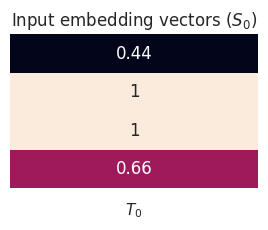

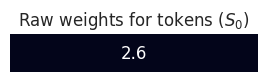

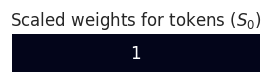

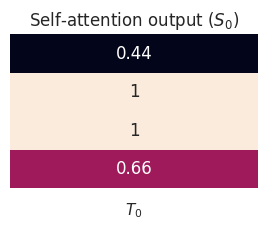

In [3]:
apply_self_attention(sequences=1, tokens_in_sequence=1, embedding_vector_dims=4)


Due to the softmax scaling function having only a single value to operate upon, the self attention output conforms to the input completely. Weight calculation is just a simple sequence-wise matrix multiplication.

Next, let's take a look at two-token sequence. Note though, that the visualizations consider only the first sequence in any case.

{'x.shape': torch.Size([1, 2, 4])}
{'raw_weights.shape': torch.Size([1, 2, 2])}
{'weights.shape': torch.Size([1, 2, 2])}
{'y.shape': torch.Size([1, 2, 4])}


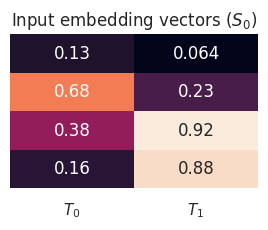

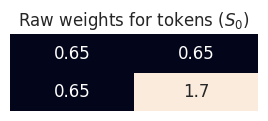

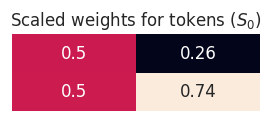

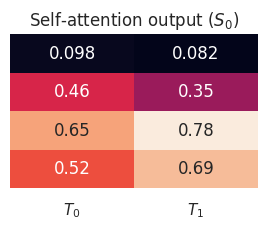

In [4]:
apply_self_attention(sequences=1, tokens_in_sequence=2, embedding_vector_dims=4)


Here we already see difference between self-attention outputs and inputs. The effects of matrix multiplication show better.

### Scaling the dot product

The softmax function can be sensitive to very large input values. These kill the gradient, and slow down learning, or cause it to stop altogether. Since the average value of the dot product grows with the embedding dimension k, it helps to scale the dot product back a little to stop the inputs to the softmax function from growing too large:

$$\begin{aligned}
w_{ij}^{'} & = {q_i^Tk_j \over \sqrt{k}} 
\end{aligned}$$

> Why $\sqrt{k}$? Imagine a vector in ℝk with values all c. Its Euclidean length is $\sqrt{kc}$. Therefore, we are dividing out the amount by which the increase in dimension increases the length of the average vectors.

As the change is minor, its enough to just show the change in code:

```python
    
    # ...
    # stuff done before in the function

    raw_weights = torch.bmm(x, x.transpose(1, 2))/torch.sqrt(embedding_vector_dims)
    print({"raw_weights.shape": raw_weights.shape})

    # stuff done after in the function
    # ...

```

### Queries, keys and values

In the basic self-attention we've seen so far, each input vector must play all three roles. We make its life a little easier by deriving new vectors for each role, by applying a linear transformation to the original input vector. 

In a transformer model, the query, key, and value are components of the self-attention mechanism used to compute attention scores between input elements. Overall, the query, key, and value enable the transformer to dynamically focus its attention on the most relevant parts of the input sequence, allowing for more effective processing and prediction. 

- __Query__: An input token vector is compared to every other vector to establish the weights for its own output . Query is used to identify the parts of the input sequence that are most relevant to the current task.

$$x_i \to y_i$$

- __Key__: An input token vector is compared to every other vector to establish the weights for the output of those vectors. Keys are used to "answer" the query by computing a similarity score between the query and each key vector.

$$x_i \to y_j$$

- __Value__: An input token vector vectors is used as part of the weighted sum to compute each output vector once the weights have been established, i.e., to compute the output of the attention mechanism. Specifically, the attention scores between the query and key are used to weight the value vectors, and then a weighted sum of the values is computed to produce the output.

The linear transformation for the query, key and value self-attention mechanism can be defined as

$$\begin{aligned}
q_i = W_qx_i \enskip , \quad k_i & = W_kx_i \enskip , \quad v_i = W_vx_i \\
w'_{ij} & = q_i^Tk_j \\
w_{ij} & = \text{softmax}(w'_{ij}) \\
y_i & = \sum_jw_{ij}v_j \\
\end{aligned}$$

where $q$ is the query matrix, $k$ the key matrix and $v$ the value matrix. The $W_q$, $W_k$ and $W_v$ are $k \times k$ weight matrices. The $w'_{ij}$ are the raw weights, $w_{ij}$ the scaled weights and $y_i$ the output of the self-attention mechanism. 

> __From this definition we can see, that by the use of key vectors the context of the whole sequence is taken into account when calculating token-wise self-attention outputs.__

Let's then define an example of the self-attention qith queries, keys and values. We stick to just figuring out the process and leave any architectural definitions of layers and such for later. 

The `apply_self_attention_with_qkv` function applies the self-attention mechanism with query, key, and value components to a random sequence of embeddings. It first generates a random sequence of embeddings and three weight matrices for the query, key, and value components. Then, it computes the query, key, and value vectors by performing matrix multiplication between the weight matrices and the embeddings. The function then computes the raw and scaled weights for each token in the sequence using the self-attention mechanism, and applies the attention to the value vectors to obtain an attention-weighted output.

In [7]:
def apply_self_attention_with_qkv(
    sequences, tokens_in_sequence, embedding_vector_dims, visualize=True
):
    """
    Apply self-attention mechanism with query, key, and value components to a random sequence of embeddings.
    """
    x = torch.rand(sequences, tokens_in_sequence, embedding_vector_dims)
    print({"x.shape": x.shape})

    W_q = torch.rand(1, embedding_vector_dims, embedding_vector_dims)
    W_k = torch.rand(1, embedding_vector_dims, embedding_vector_dims)
    W_v = torch.rand(1, embedding_vector_dims, embedding_vector_dims)

    q = torch.bmm(W_q, x.transpose(1, 2))
    print({"q.shape": q.shape})
    k = torch.bmm(W_k, x.transpose(1, 2))
    print({"k.shape": k.shape})
    v = torch.bmm(W_v, x.transpose(1, 2))
    print({"v.shape": v.shape})

    raw_weights = torch.bmm(q, k.transpose(1, 2)) / torch.sqrt(
        torch.tensor(embedding_vector_dims)
    )
    print({"raw_weights.shape": raw_weights.shape})

    weights = F.softmax(raw_weights, dim=2)
    print({"weights.shape": weights.shape})

    y = torch.bmm(weights, v).transpose(1, 2)
    print({"y.shape": y.shape})

    if visualize:
        visualize_self_attention(
            x,
            raw_weights,
            weights,
            y,
            q,
            k,
            v,
        )


Let's then see what happens with a two-token sequence with queries, keys and values implementation of the self-attention mechanism.  The legend for notation is the following:
 - $S_0$ is the first sequence of tokens in the input batch
 - $T$ are the token-wise embedding vectors in an input sequence
 - $Q$ are the query vectors
 - $K$ are the key vectors
 - $V$ are the value vectors

{'x.shape': torch.Size([1, 2, 4])}
{'q.shape': torch.Size([1, 4, 2])}
{'k.shape': torch.Size([1, 4, 2])}
{'v.shape': torch.Size([1, 4, 2])}
{'raw_weights.shape': torch.Size([1, 4, 4])}
{'weights.shape': torch.Size([1, 4, 4])}
{'y.shape': torch.Size([1, 2, 4])}


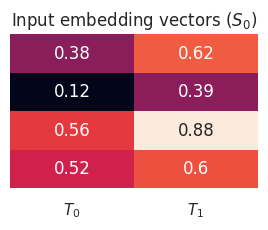

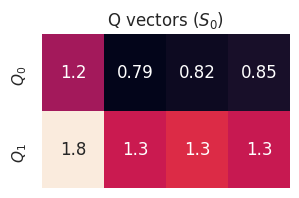

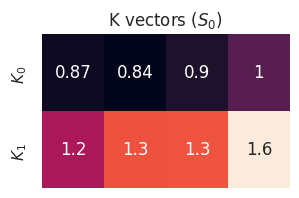

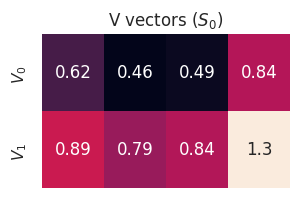

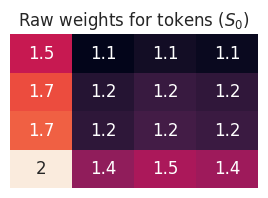

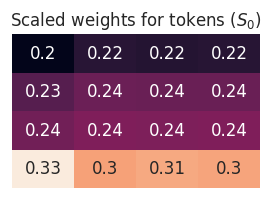

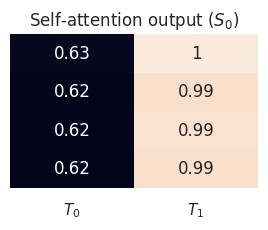

In [8]:
apply_self_attention_with_qkv(
    sequences=1, tokens_in_sequence=2, embedding_vector_dims=4
)


Instead of changing single embedding values for each token, the tokens are now weighted in relation to other tokens. 

### Multi-head attention

In a single query, key and value self-attention operation, all information about the sequence just gets summed together. This means there is just a single way the influence of tokens to other tokens gets modelled. 

We can give the self attention greater power of discrimination, by combining several self-attention mechanisms (which we'll index with $r$), each with different matrices $W_q^r$, $W_k^r$ and $W_v^r$. These are called __attention heads__. For input token $x_i$ each attention head produces a different output vector $y_i^r$. These are then concatenated and passed through a linear transformation to reduce the dimension back to $k$.

The simplest way to understand multi-head self-attention is to see it as a small number of copies of the self-attention mechanism applied in parallel, each with their own key, value and query transformation. To accomplish this, each head receives low-dimensional keys queries and values. If the input vector has $k=256$ embedding dimensions, and we have $h=4$ attention heads, we multiply the input vectors by a $256\times64$ matrix to project them down to a sequence of 64 dimensional vectors. For every head, we do this 3 times: for the keys, the queries and the values.

Practically this means, that the self-attention operation is just copied over as many times as there are heads. Each attention head gets its own separately initialized weight matrices. This helps the transformer model to learn multiple and different ways for the tokens to influence each other.

This and the transformer model will be imeplement in the next notebook.